In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import mne
from data_util import load_data, euclidean_alignment
from braindecode.datasets import BaseConcatDataset
from copy import deepcopy

In [2]:
channels = [
    "Fp1", "Fp2",
    "F7", "F3", "Fz", "F4", "F8",
    "FT9", "FC5", "FC1", "FC2", "FC6", "FT10",
    "T7", "C3", "Cz", "C4", "T8",
    "CP5", "CP1", "CP2", "CP6",
    "P7", "P3", "Pz", "P4", "P8",
    "PO9", "O1", "Oz", "O2", "PO10",
]

In [3]:
# physionet
fnames = mne.datasets.eegbci.load_data(subject=15, runs=(4, 8, 12))
hand_raw = mne.concatenate_raws([mne.io.read_raw_edf(f, preload=True) for f in fnames])

stim = hand_raw.annotations.description.astype(np.dtype("<U10"))
stim[stim == "T0"] = "rest"
stim[stim == "T1"] = "left_hand"
stim[stim == "T2"] = "right_hand"
hand_raw.annotations.description = stim

fnames = mne.datasets.eegbci.load_data(subject=15, runs=(6, 10, 14))
feet_raw = mne.concatenate_raws([mne.io.read_raw_edf(f, preload=True) for f in fnames])

stim = feet_raw.annotations.description.astype(np.dtype("<U10"))
stim[stim == "T0"] = "rest"
stim[stim == "T1"] = "hands"
stim[stim == "T2"] = "feet"
feet_raw.annotations.description = stim

raw = mne.concatenate_raws([hand_raw, feet_raw])
raw.rename_channels(lambda x: x.strip('.'))
raw.rename_channels(lambda x: x.upper())
raw.rename_channels({
    "AFZ": "AFz", "PZ": "Pz", "FPZ": "Fpz", "FCZ": "FCz", "FP1": "Fp1", "CZ": "Cz",
    "OZ": "Oz", "POZ": "POz", "IZ": "Iz", "CPZ": "CPz", "FP2": "Fp2", "FZ": "Fz",
})
raw.set_montage("standard_1005")

<RawEDF | S015R04.edf, 64 x 118080 (738.0 s), ~57.7 MB, data loaded>

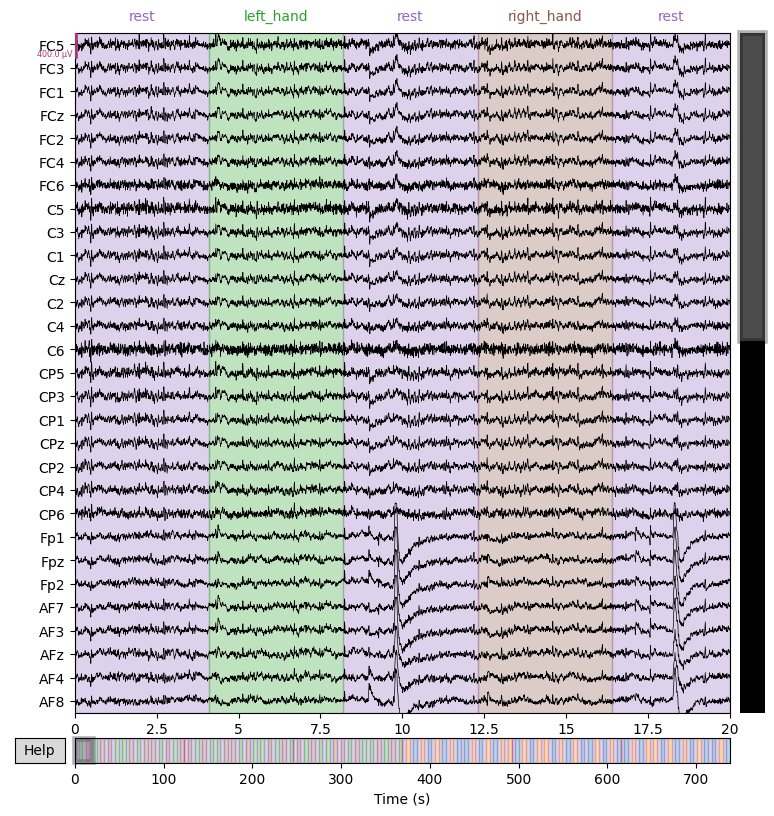

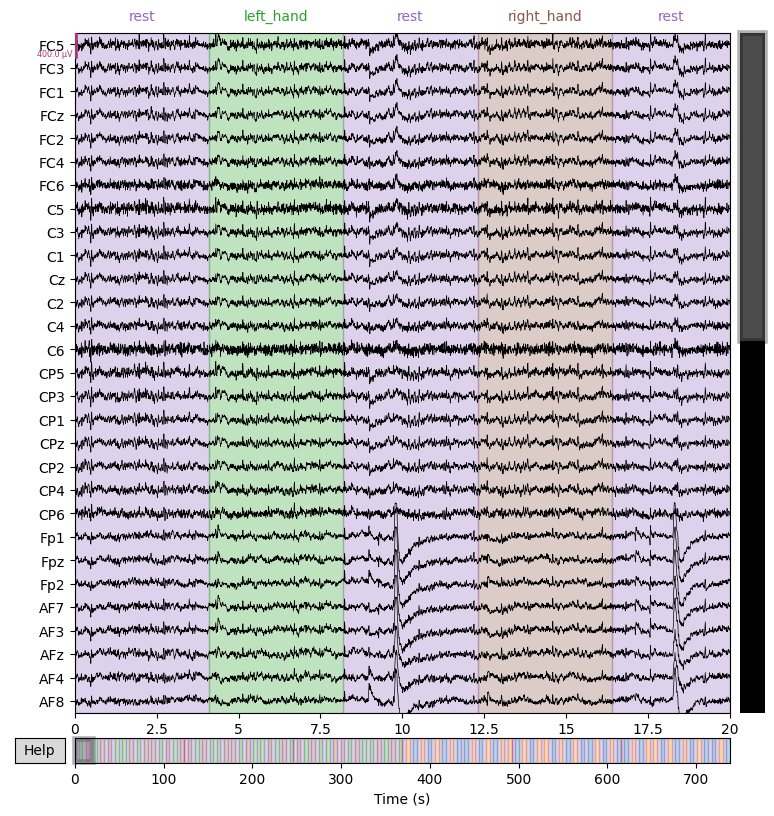

In [25]:
raw.plot(n_channels=29, scalings={"eeg": 2e-4}, duration=20)
# raw.plot(n_channels=64, scalings="auto", duration=20)

In [371]:
events, event_id = mne.events_from_annotations(raw)
event_id

{'feet': 1, 'hands': 2, 'left_hand': 3, 'rest': 4, 'right_hand': 5}

In [395]:
tmin, tmax = -0.5, 3

# event_id = {'feet': 1, 'left_hand': 3, 'rest': 4, 'right_hand': 5}
event_id = {'feet': 1, 'left_hand': 3, 'right_hand': 5}
# event_id = {'left_hand': 3, 'right_hand': 5}
# event_id = {'feet': 1, 'hands': 2}

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=('C3', 'Cz', 'C4'), baseline=None, preload=True)

In [396]:
freqs = np.arange(4, 40)

tfr = mne.time_frequency.tfr_multitaper(epochs, freqs=freqs, n_cycles=freqs, use_fft=True, return_itc=False, average=False, decim=2)
tfr.crop(tmin, tmax).apply_baseline([tmin, 0], mode="percent")

<EpochsTFR | time : [-0.500000, 3.000000], freq : [4.000000, 39.000000], epochs : 68, channels : 3, ~15.8 MB>

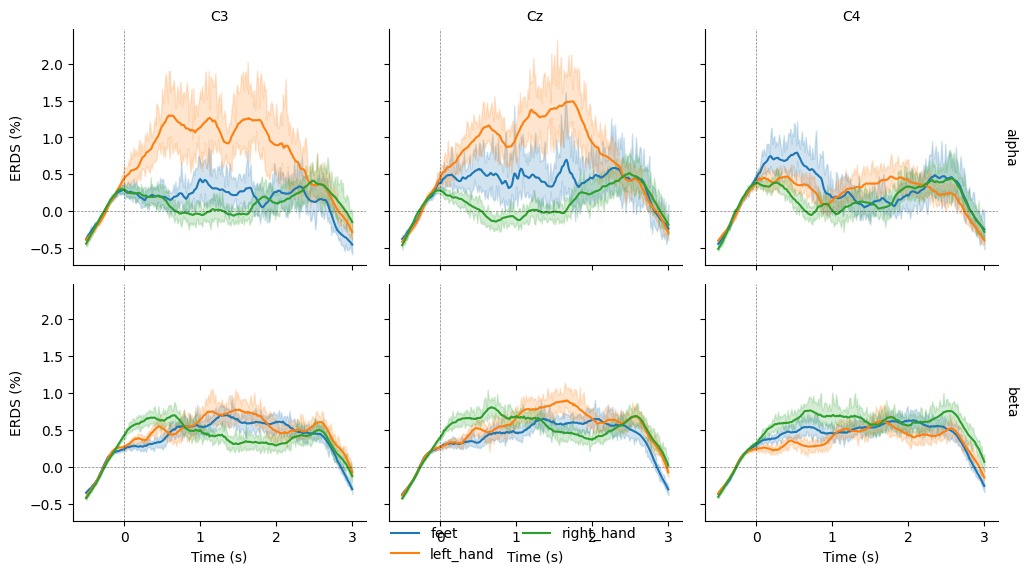

In [397]:
df = tfr.to_data_frame(time_format=None, long_format=True)

# Map to frequency bands:
freq_bounds = {'_': 0,
               'delta': 4,
               'theta': 8,
               'alpha': 12,
               'beta': 30,
               'gamma': 80}
df['band'] = pd.cut(df['freq'], list(freq_bounds.values()),
                    labels=list(freq_bounds)[1:])

# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ['alpha', 'beta']
df = df[df.band.isin(freq_bands_of_interest)]
df['band'] = df['band'].cat.remove_unused_categories()

# Order channels for plotting:
df['channel'] = df['channel'].cat.reorder_categories(('C3', 'Cz', 'C4'),
                                                     ordered=True)

g = sb.FacetGrid(df, row='band', col='channel', margin_titles=True)
g.map(sb.lineplot, 'time', 'value', 'condition', n_boot=10)
axline_kw = dict(color='black', linestyle='dashed', linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)
# g.set(ylim=(None, 1.5))
g.set_axis_labels("Time (s)", "ERDS (%)")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc='lower center')
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)

In [416]:
alpha = dict()
beta = dict()
for k, _ in event_id.items():
    alpha[k] = epochs[k].copy().filter(l_freq=8, h_freq=12).get_data()
    beta[k] = epochs[k].copy().filter(l_freq=12, h_freq=30).get_data()
    
    # alpha[k] -= alpha[k].mean(axis=0, keepdims=True)
    # beta[k] -= beta[k].mean(axis=0, keepdims=True)
    
    alpha[k] = (alpha[k] * alpha[k]).mean(axis=0)
    beta[k] = (beta[k] * beta[k]).mean(axis=0)
    
    alpha_base = alpha[k][:, :int(abs(tmin) * 160)].mean(axis=1, keepdims=True)
    beta_base = beta[k][:, :int(abs(tmin) * 160)].mean(axis=1, keepdims=True)
    # print(alpha_base.shape)
    
    alpha[k] = (alpha[k] - alpha_base) / alpha_base * 100
    beta[k] = (beta[k] - beta_base) / beta_base * 100

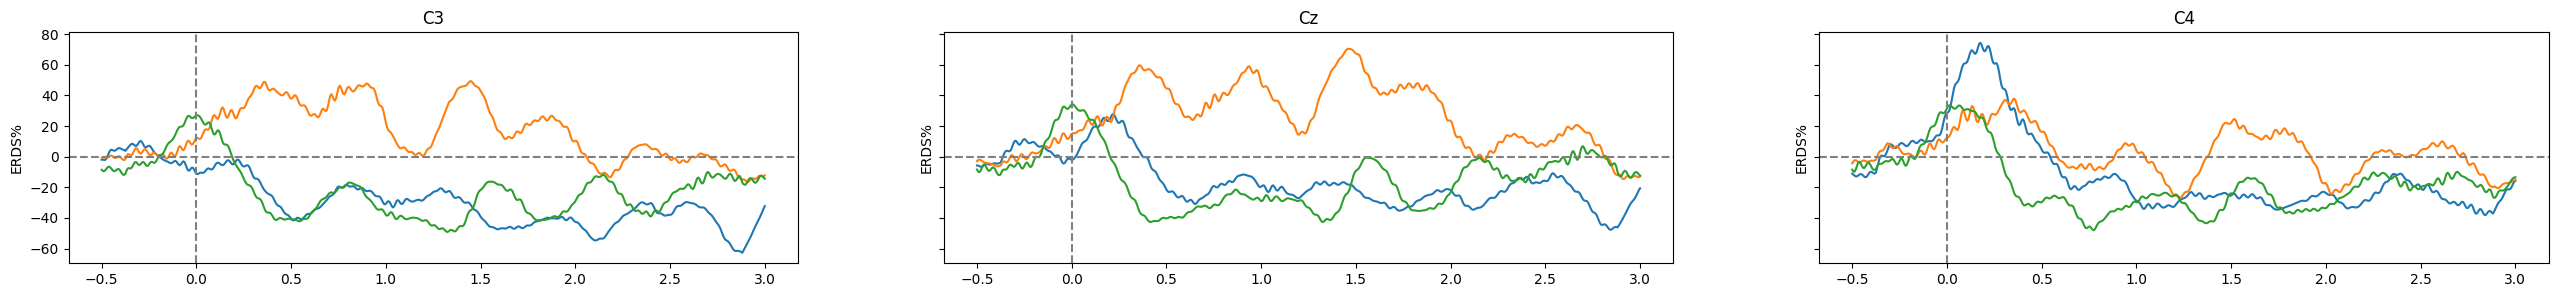

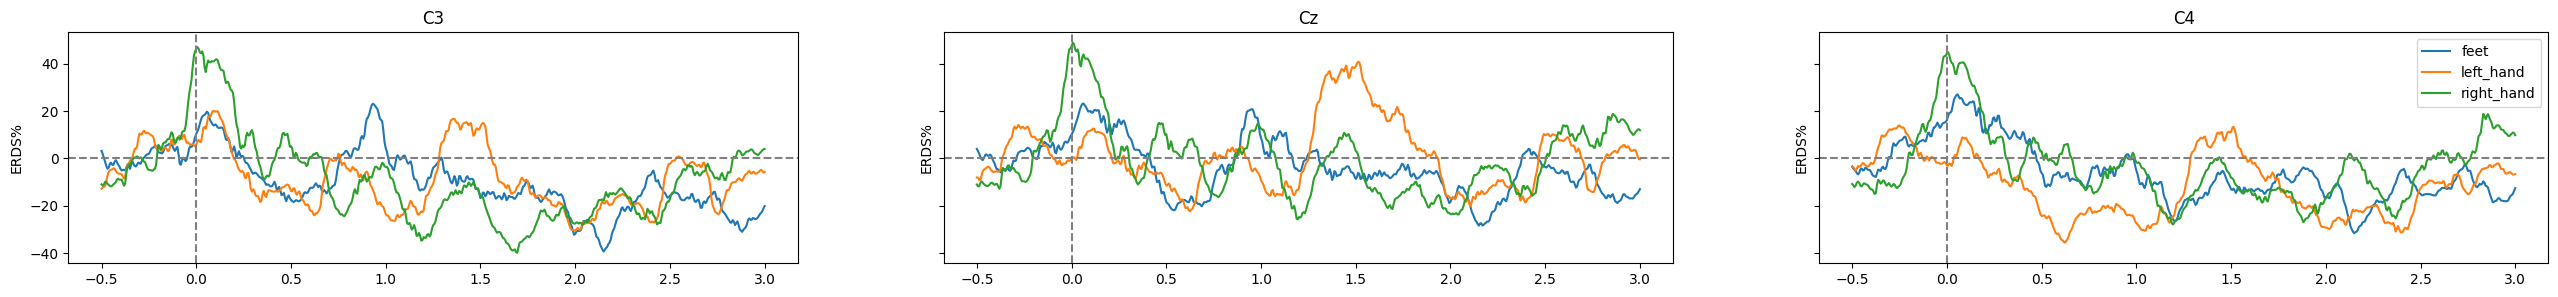

In [417]:
_, axes = plt.subplots(nrows=1, ncols=3, sharey='row', figsize=(32, 3))
cols = ['C3', 'Cz', 'C4']

for i in range(3):
    for k, v in alpha.items():
        axes[i].plot(np.linspace(tmin, tmax, len(v[i])), np.convolve(v[i], np.ones(40) / 40, mode='same'))
    axes[i].axhline(y=0, color='gray', linestyle='--')
    axes[i].axvline(x=0, color='gray', linestyle='--')
    axes[i].set_title(cols[i])
    axes[i].set_ylabel('ERDS%')
    
_, axes = plt.subplots(nrows=1, ncols=3, sharey='row', figsize=(32, 3))
for i in range(3):
    for k, v in beta.items():
        axes[i].plot(np.linspace(tmin, tmax, len(v[i])), np.convolve(v[i], np.ones(40) / 40, mode='same'))
    axes[i].axhline(y=0, color='gray', linestyle='--')
    axes[i].axvline(x=0, color='gray', linestyle='--')
    axes[i].set_title(cols[i])
    axes[i].set_ylabel('ERDS%')
    
plt.legend(alpha.keys())

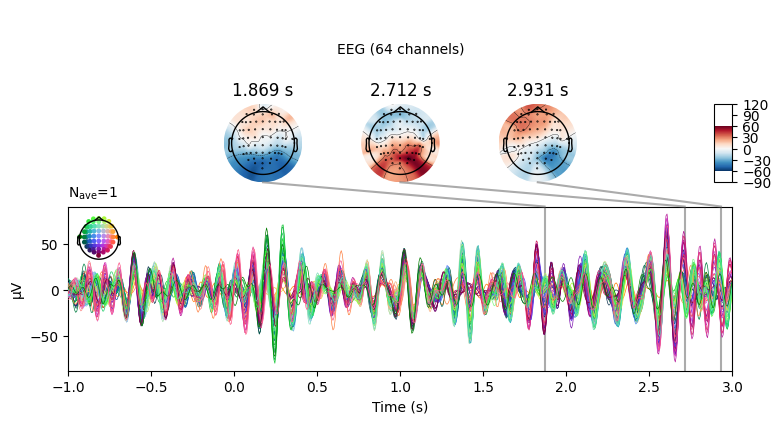

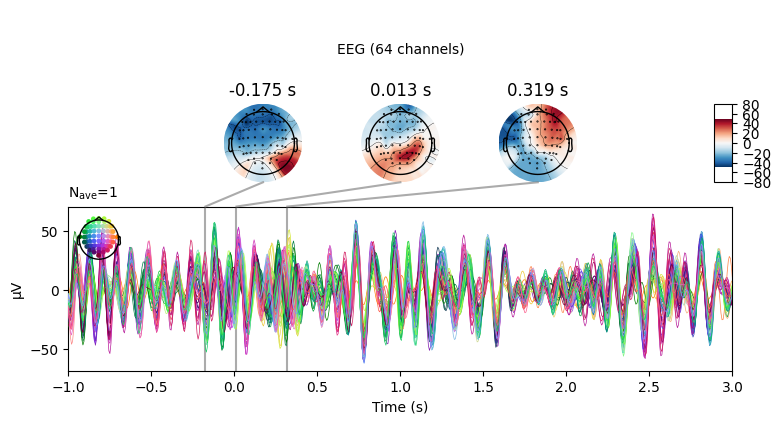

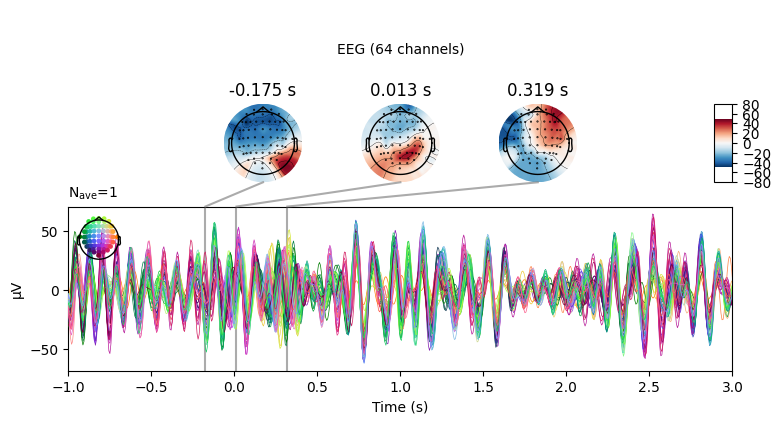

In [385]:
# epochs['left_hand'].plot_psd_topomap(bands=[(8,12,'Alpha'), (12,30,'Beta')])
epochs0 = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=None, preload=True)

epochs0['left_hand'].copy().filter(l_freq=8, h_freq=12)[0].average().plot_joint()
epochs0['right_hand'].copy().filter(l_freq=8, h_freq=12)[0].average().plot_joint()

In [156]:
left_raw = mne.io.read_raw_edf("../data/DataVIN/Official/K309/sample1/EEG.edf", preload=True, verbose=False)

stim = left_raw.annotations.description.astype(np.dtype("<U19"))
stim[stim == "Thinking"] = "nâng tay trái"
left_raw.annotations.description = stim

right_raw = mne.io.read_raw_edf("../data/DataVIN/Official/K309/sample2/EEG.edf", preload=True, verbose=False)

stim = right_raw.annotations.description.astype(np.dtype("<U19"))
stim[stim == "Thinking"] = "nâng tay phải"
right_raw.annotations.description = stim

raw = mne.concatenate_raws([left_raw, right_raw])
raw.set_montage("standard_1020")

<RawEDF | EEG.edf, 32 x 33920 (265.0 s), ~8.3 MB, data loaded>

In [73]:
events, event_id = mne.events_from_annotations(raw)
event_id

Used Annotations descriptions: ['Resting', 'Thinking and Acting', 'Typing', 'nâng tay phải', 'nâng tay trái']


{'Resting': 1,
 'Thinking and Acting': 2,
 'Typing': 3,
 'nâng tay phải': 4,
 'nâng tay trái': 5}

In [86]:
tmin, tmax = -1, 4

event_id = {'Resting': 1, 'nâng tay trái': 5, "nâng tay phải": 4}
# event_id = {'Resting': 1}

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=('C3', 'Cz', 'C4'), baseline=None, preload=True)

Not setting metadata
18 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 18 events and 641 original time points ...
0 bad epochs dropped


In [87]:
tfr = mne.time_frequency.tfr_multitaper(epochs, freqs=freqs, n_cycles=freqs, use_fft=True, return_itc=False, average=False, decim=2)
tfr.crop(tmin, tmax).apply_baseline([-1, 0], mode="percent")

Not setting metadata
Applying baseline correction (mode: percent)


<EpochsTFR | time : [-1.000000, 4.000000], freq : [4.000000, 38.000000], epochs : 18, channels : 3, ~4.7 MB>

Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "freq" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...


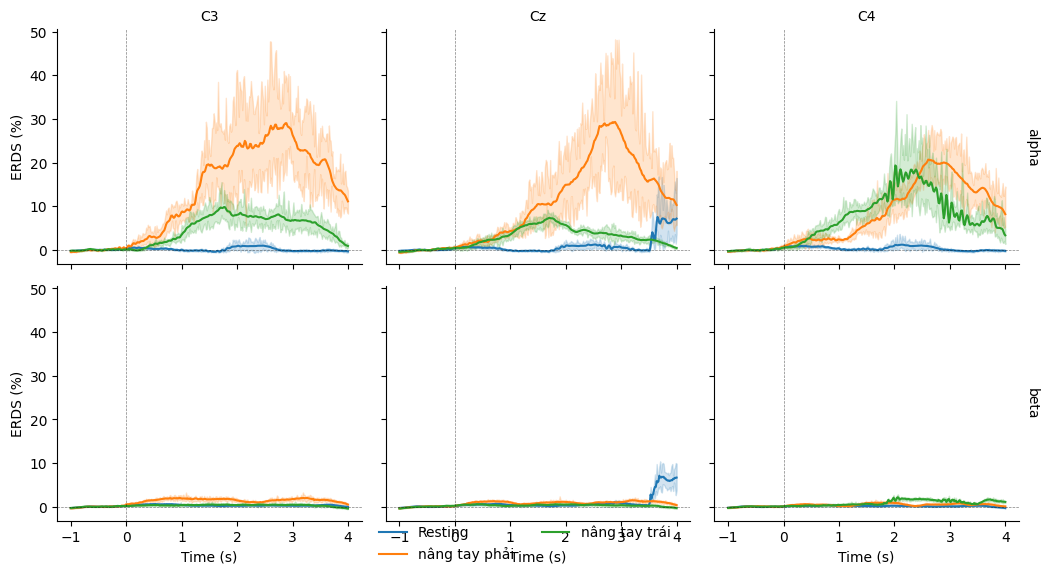

In [88]:
df = tfr.to_data_frame(time_format=None, long_format=True)

# Map to frequency bands:
freq_bounds = {'_': 0,
               'delta': 4,
               'theta': 8,
               'alpha': 12,
               'beta': 30,
               'gamma': 80}
df['band'] = pd.cut(df['freq'], list(freq_bounds.values()),
                    labels=list(freq_bounds)[1:])

# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ['alpha', 'beta']
df = df[df.band.isin(freq_bands_of_interest)]
df['band'] = df['band'].cat.remove_unused_categories()

# Order channels for plotting:
df['channel'] = df['channel'].cat.reorder_categories(('C3', 'Cz', 'C4'),
                                                     ordered=True)

g = sb.FacetGrid(df, row='band', col='channel', margin_titles=True)
g.map(sb.lineplot, 'time', 'value', 'condition', n_boot=10)
axline_kw = dict(color='black', linestyle='dashed', linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)
# g.set(ylim=(None, 1.5))
g.set_axis_labels("Time (s)", "ERDS (%)")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc='lower center')
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)

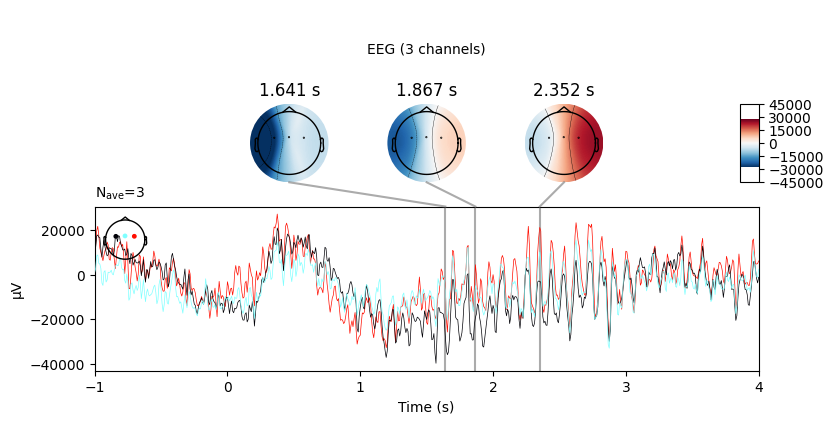

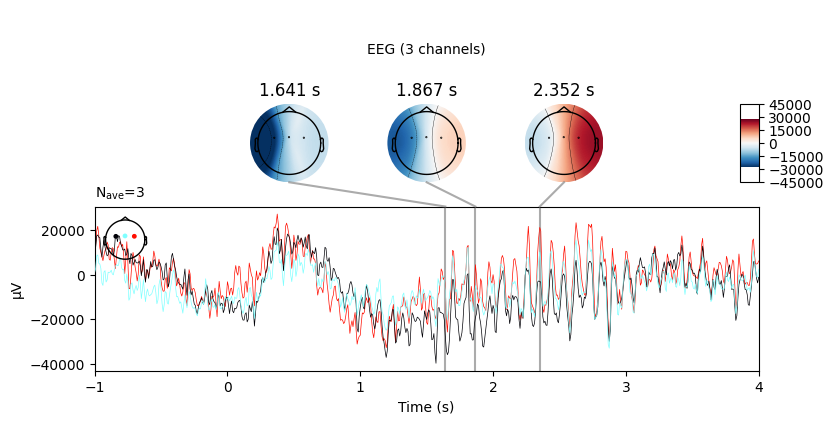

In [97]:
epochs["nâng tay phải"].average().plot_joint()

In [7]:
%%time
# fmt: off
subjects = [
    'K001', 'K002', 'K003', 'K004', 'K005', 
    'K006', 'K007', 'K008', 'K009', 'K010', 
    'K011', 'K012', 'K013', 'K015', 'K016', 
    'K017', 'K018', 'K021', 'K022', 'K023', 
    'K024', 'K025', 'K026', 'K027', 'K028', 
    'K300', 'K301', 'K302', 'K303', 'K304', 
    'K305', 'K306', 'K307', 'K308', 'K309', 
    'K310', 'K311', 'K312', 'K313', 'K314', 
    'K315', 'K316', 'K319', 'K320', 'K321', 
    'K322', 'K323', 'K324', 'K325', 'K326', 
    'K327', 'K328', 'K329', 'K330', 'K331', 
    'K332', 'K333', 'K334', 'K335', 'K336', 
    'K337', 'K338', 'K339', 'K342', 'K343', 
    'K344', 'K350', 'K351', 'K352', 'K353', 
    'K354', 'K355', 'K357', 'K358', 'K359', 
    'K360', 'K361', 'K362', 'K364', 'K365', 
    'K366', 'K367', 'K368', 'K369', 'K370', 
    'K371', 'K372', 'K373', 'K374', 'K375',
]

subjects = sorted(subjects)

scenarios = [
    "nâng tay trái",
    "nâng tay phải",
    # "nâng chân trái",
    # "nâng chân phải",
    # "gật đầu",
    # "lắc đầu",
    # "há miệng",
]

events = [
    "Thinking",
    # "Thinking and Acting",
    "Resting",
    # "Typing",
]

channels = [
    "Fp1", "Fp2",
    "F7", "F3", "Fz", "F4", "F8",
    # "FT9", "FC5", "FC1", "FC2", "FC6", "FT10",
    "FC5", "FC1", "FC2", "FC6",
    "T7", "C3", "Cz", "C4", "T8",
    # "C3", "Cz", "C4",
    "CP5", "CP1", "CP2", "CP6",
    "P7", "P3", "Pz", "P4", "P8",
    # "PO9", "O1", "Oz", "O2", "PO10",
    "O1", "Oz", "O2",
]

label_mapping={
    "nâng tay trái_Thinking": "nâng tay trái",
    "nâng tay phải_Thinking": "nâng tay phải",
    # "nâng tay trái_Thinking": "nâng tay",
    # "nâng tay phải_Thinking": "nâng tay",
    # "nâng chân trái_Thinking": "nâng chân trái",
    # "nâng chân phải_Thinking": "nâng chân phải",
    "nâng chân trái_Thinking": "nâng chân",
    "nâng chân phải_Thinking": "nâng chân",
    # "gật đầu_Thinking": "gật đầu",
    # "lắc đầu_Thinking": "lắc đầu",
    "gật đầu_Thinking": "gật/lắc đầu",
    "lắc đầu_Thinking": "gật/lắc đầu",
    "há miệng_Thinking": "há miệng",
    # "nâng tay trái_Thinking and Acting": "nâng tay trái",
    # "nâng tay phải_Thinking and Acting": "nâng tay phải",
    # "nâng chân trái_Thinking and Acting": "nâng chân trái",
    # "nâng chân phải_Thinking and Acting": "nâng chân phải",
    # "gật đầu_Thinking and Acting": "gật đầu",
    # "lắc đầu_Thinking and Acting": "lắc đầu",
    # "há miệng_Thinking and Acting": "há miệng",
    "Resting": "rest",
}

max_duration = {  # seconds
    # "nâng tay trái": 10,
    # "nâng tay phải": 10,
    # "nâng chân trái": 10,
    # "nâng chân phải": 10,
    # "gật đầu": 10,
    # "lắc đầu": 10,
    "rest": 20,
}

n_channels = len(channels)

print(f"using {n_channels} channels")

minimal_trial_duration = 4  # @param
window_duration = 2  # @param
window_stride_duration = 0.5  # @param

fmin = 8.0  # @param
fmax = 30.0  # @param

moving_standardize = False  # @param {"type": "boolean"}

ds = load_data(
    "../data/DataVIN/Official",  
    subjects=subjects,
    scenarios=scenarios,
    events=events,
    channels=channels,
    label_mapping=label_mapping,
    minimal_trial_duration=minimal_trial_duration,
    window_duration=window_duration, 
    window_stride_duration=window_stride_duration, 
    start_offset=0,
    stop_offset=0,
    max_duration=max_duration,
    fmin=fmin, 
    fmax=fmax, 
    moving_standardize=moving_standardize,
    resample=None,
    return_raw=False,
    return_preprocessed=False,
    preload=True,
)

als_subjects = [
    *(f"ALS01_t{i}" for i in range(1, 11)),
    *(f"ALS02_t{i}" for i in range(1, 11)),
    *(f"ALS03_t{i}" for i in range(1, 10)),
    *(f"ALS04_t{i}" for i in range(1, 9)),
    *(f"ALS05_t{i}" for i in range(1, 7)),
    *(f"ALS06_t{i}" for i in range(1, 4)),
]

als_ds = load_data(
    "../data/DataVIN/ALS/als-patients",  
    subjects=als_subjects,
    scenarios=scenarios,
    events=events,
    channels=channels,
    label_mapping=label_mapping,
    minimal_trial_duration=minimal_trial_duration,
    window_duration=window_duration, 
    window_stride_duration=window_stride_duration, 
    start_offset=0,
    stop_offset=0,
    max_duration=max_duration,
    fmin=fmin, 
    fmax=fmax, 
    moving_standardize=moving_standardize,
    resample=None,
    return_raw=False,
    return_preprocessed=False,
    preload=True,
)

# ds = als_ds
# subjects = als_subjects

ds = BaseConcatDataset([ds, als_ds])
subjects.extend(als_subjects)

# fmt: on

# for _ds in ds.datasets:
#     _ds_info = _ds.description
#     if _ds_info["subject"] == "ALS01_t2":
#         _ds_info["subject"] = "ALS01_t1"
#     elif _ds_info["subject"] == "ALS01_t4":
#         _ds_info["subject"] = "ALS01_t3"
#     elif _ds_info["subject"] == "ALS01_t6":
#         _ds_info["subject"] = "ALS01_t5"

ds_info = ds.description

ds_info["epochs"] = 0
for i, r in ds_info.iterrows():
    ds_info.loc[i, "epochs"] = len(ds.datasets[i].windows)

print(f"loaded {len(ds_info['subject'].unique())} subjects - {ds_info['epochs'].sum()} epochs")
ds_info

using 28 channels


subject:   0%|                                                                                                                                                                                                                                          | 0/106 [00:00<?, ?it/s]/home/txdat/Documents/code/eeg-motor-imagery/notebooks/data_util.py:211: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
subject:  14%|███████████████████████████████▋                                                                                                                                                                                                | 15/106 [00:00<00:00, 137.12it/s]/home/txdat/Documents/code/eeg-motor-imagery/notebooks/data_util.py:211: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preloa

loaded 136 subjects - 18963 epochs
CPU times: user 36.2 s, sys: 2.21 s, total: 38.4 s
Wall time: 40.2 s


subject       scenario     event    onset          label  label_idx  \
0         K001  nâng tay trái  Thinking   6.7125  nâng tay trái          2   
1         K001  nâng tay trái   Resting  13.1479           rest          0   
2         K001  nâng tay trái   Resting  32.7215           rest          0   
3         K001  nâng tay trái  Thinking  37.0182  nâng tay trái          2   
4         K001  nâng tay trái  Thinking  62.7771  nâng tay trái          2   
...        ...            ...       ...      ...            ...        ...   
1670  ALS06_t3  nâng tay phải   Resting  19.4459           rest          0   
1671  ALS06_t3  nâng tay phải  Thinking  27.6958  nâng tay phải          1   
1672  ALS06_t3  nâng tay phải   Resting  40.0924           rest          0   
1673  ALS06_t3  nâng tay phải  Thinking  46.6595  nâng tay phải          1   
1674  ALS06_t3  nâng tay phải   Resting  58.1066           rest          0   

      trial  split  epochs  
0         0  train       9  
1         0  train      10  
2         1  train       5  
3         1  train      10  
4         2  train      10  
...     ...    ...     ...  
1670      0  train      13  
1671      1  train      21  
1672      1  train      10  
1673      2  train      19  
1674      2  train       6  

[1675 rows x 9 columns]

In [92]:
subds = BaseConcatDataset([deepcopy(ds.datasets[i]) for i in ds_info[ds_info["subject"].isin(["K315"])].index])
# euclidean_alignment(subds, target_subject=None)
subds_info = subds.description

subds_info

subject       scenario     event     onset          label  label_idx  \
0     K315  nâng tay trái  Thinking   16.7165  nâng tay trái          2   
1     K315  nâng tay trái   Resting   23.5314           rest          0   
2     K315  nâng tay trái   Resting   40.4585           rest          0   
3     K315  nâng tay trái  Thinking   48.3722  nâng tay trái          2   
4     K315  nâng tay trái   Resting   56.7036           rest          0   
5     K315  nâng tay trái   Resting   74.2479           rest          0   
6     K315  nâng tay trái  Thinking   81.0134  nâng tay trái          2   
7     K315  nâng tay trái   Resting   88.9264           rest          0   
8     K315  nâng tay trái   Resting  104.2386           rest          0   
9     K315  nâng tay phải  Thinking    9.5001  nâng tay phải          1   
10    K315  nâng tay phải   Resting   16.6656           rest          0   
11    K315  nâng tay phải   Resting   31.4272           rest          0   
12    K315  nâng tay phải  Thinking   38.1741  nâng tay phải          1   
13    K315  nâng tay phải   Resting   46.1551           rest          0   
14    K315  nâng tay phải   Resting   61.0512           rest          0   
15    K315  nâng tay phải  Thinking   68.0657  nâng tay phải          1   
16    K315  nâng tay phải   Resting   75.1628           rest          0   
17    K315  nâng tay phải   Resting   91.6236           rest          0   

    trial  split  
0       0  train  
1       0  train  
2       1  train  
3       1  train  
4       2  train  
5       3  train  
6       2  train  
7       4  train  
8       5  train  
9       0  train  
10      0  train  
11      1  train  
12      1  train  
13      2  train  
14      3  train  
15      2  train  
16      4  train  
17      5  train

In [95]:
epochs = mne.concatenate_epochs([subds.datasets[i].windows for i in subds_info[subds_info["label"] == "nâng tay trái"].index])
# epochs = mne.concatenate_epochs([_ds.windows for _ds in subds.datasets])
epochs

<Epochs |  35 events (all good), 0 - 1.99219 sec, baseline off, ~2.0 MB, data loaded, with metadata,
 'rest': 0
 'nâng tay phải': 0
 'nâng tay trái': 35>

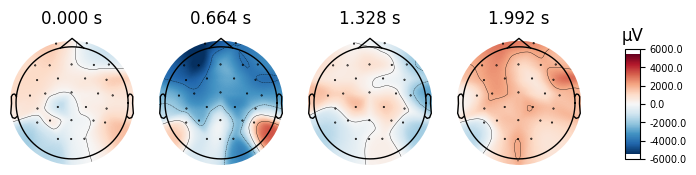

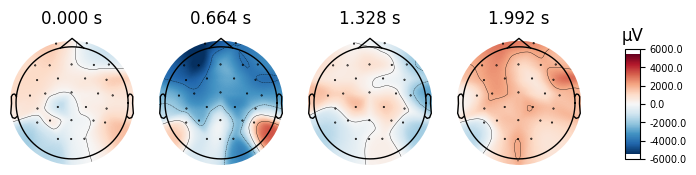

In [96]:
# epochs.plot_psd_topomap(bands=[(8, 12, "Alpha")])
epochs.average().plot_topomap()
# epochs.copy().pick_channels(ch_names=["P7", "P3", "Pz", "P4", "P8", "O1", "Oz", "O2"]).plot_psd()
# epochs.copy().pick_channels(ch_names=["C3", "Cz", "C4"]).plot_psd()

In [39]:
euclidean_alignment(ds, target_subject=None)

subject: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:01<00:00, 83.49it/s]


In [63]:
subds = BaseConcatDataset([ds.datasets[i] for i in ds_info[ds_info["subject"].str.startswith("ALS01")].index])
subds_info = subds.description
subds_info

subject       scenario     event    onset          label  label_idx  \
0    ALS01_t1  nâng tay trái  Thinking  14.5376  nâng tay trái          2   
1    ALS01_t1  nâng tay trái   Resting  26.3349           rest          0   
2    ALS01_t1  nâng tay trái  Thinking  41.2796  nâng tay trái          2   
3    ALS01_t1  nâng tay trái   Resting  52.9240           rest          0   
4    ALS01_t1  nâng tay trái  Thinking  63.0225  nâng tay trái          2   
..        ...            ...       ...      ...            ...        ...   
107  ALS01_t9  nâng tay phải   Resting  15.9656           rest          0   
108  ALS01_t9  nâng tay phải  Thinking  23.3039  nâng tay phải          1   
109  ALS01_t9  nâng tay phải   Resting  34.9498           rest          0   
110  ALS01_t9  nâng tay phải  Thinking  40.9985  nâng tay phải          1   
111  ALS01_t9  nâng tay phải   Resting  54.9758           rest          0   

     trial  split  
0        0  train  
1        0  train  
2        1  train  
3        1  train  
4        2  train  
..     ...    ...  
107      0  train  
108      1  train  
109      1  train  
110      2  train  
111      2  train  

[112 rows x 8 columns]

In [75]:
epochs = mne.concatenate_epochs([subds.datasets[i].windows for i in subds_info[subds_info["label"] == "rest"].index])
epochs

<Epochs |  608 events (all good), 0 - 1.99219 sec, baseline off, ~33.3 MB, data loaded, with metadata,
 'rest': 608
 'nâng tay phải': 0
 'nâng tay trái': 0>

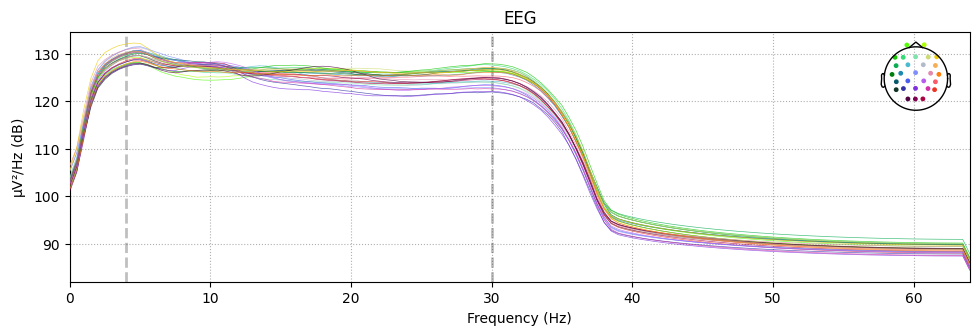

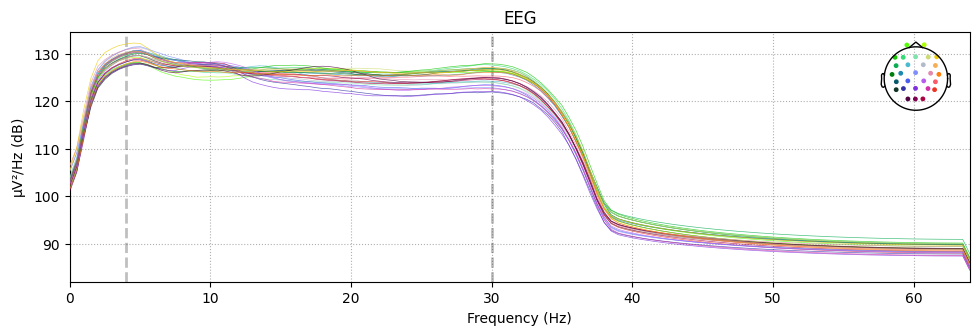

In [76]:
epochs.plot_psd()

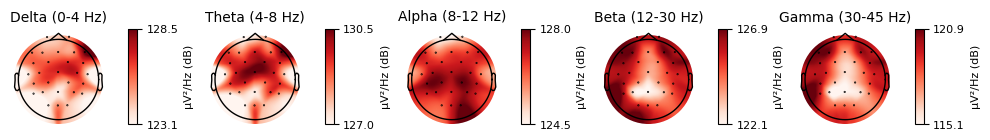

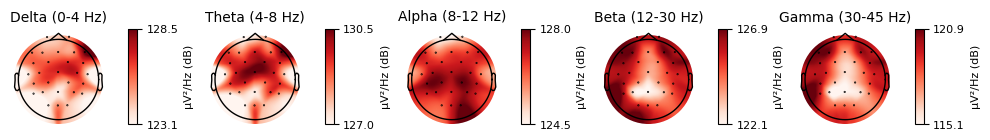

In [77]:
epochs.plot_psd_topomap()

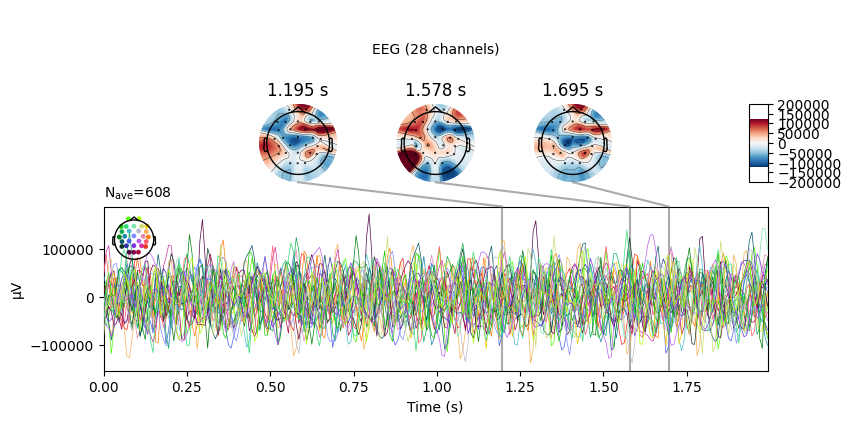

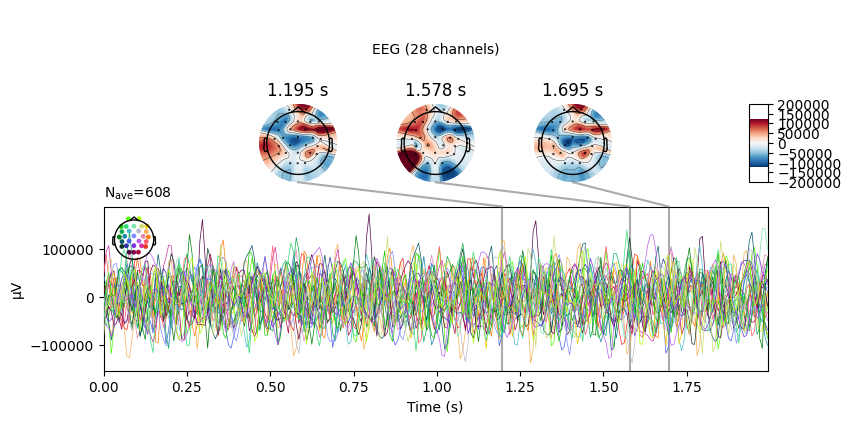

In [78]:
epochs.average().plot_joint()

In [635]:
euclidean_alignment(ds, target_subject=None)

subject: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:00<00:00, 109.42it/s]


In [4]:
epochs = mne.concatenate_epochs([_ds.windows.copy() for _ds in ds.datasets])
epochs = epochs.pick_channels(ch_names=["C3", "Cz", "C4"], ordered=True)
epochs

<Epochs |  266 events (all good), 0 - 1.99219 sec, baseline off, ~1.6 MB, data loaded, with metadata,
 'rest': 167
 'nâng chân': 57
 'nâng tay phải': 21
 'nâng tay trái': 21>

In [5]:
epochs.event_id

{'rest': 0, 'nâng chân': 1, 'nâng tay phải': 2, 'nâng tay trái': 3}

In [10]:
tmin = 0
tmax = 2

alpha = dict()
beta = dict()
for k, _ in epochs.event_id.items():
    alpha[k] = epochs[k].copy().filter(l_freq=8, h_freq=12).get_data()
    beta[k] = epochs[k].copy().filter(l_freq=12, h_freq=30).get_data()
    print(alpha[k].shape)
    
    # alpha[k] -= alpha[k].mean(axis=0, keepdims=True)
    # beta[k] -= beta[k].mean(axis=0, keepdims=True)
    
    alpha[k] = (alpha[k] * alpha[k]).mean(axis=0)
    beta[k] = (beta[k] * beta[k]).mean(axis=0)
    
#     alpha_base = alpha[k][:, :int(abs(1) * 128)].mean(axis=1, keepdims=True)
#     beta_base = beta[k][:, :int(abs(1) * 128)].mean(axis=1, keepdims=True)
#     # print(alpha_base.shape)
    
#     alpha[k] = (alpha[k] - alpha_base) / alpha_base * 100
#     beta[k] = (beta[k] - beta_base) / beta_base * 100

alpha_base = alpha["rest"].mean(axis=1, keepdims=True)
beta_base = beta["rest"].mean(axis=1, keepdims=True)

for k, v in alpha.items():
    if k == "rest":
        continue
        
    alpha[k] = (v - alpha_base) / alpha_base * 100
    
for k, v in beta.items():
    if k == "rest":
        continue
        
    beta[k] = (v - beta_base) / beta_base * 100
    

(167, 3, 256)
(57, 3, 256)
(21, 3, 256)
(21, 3, 256)


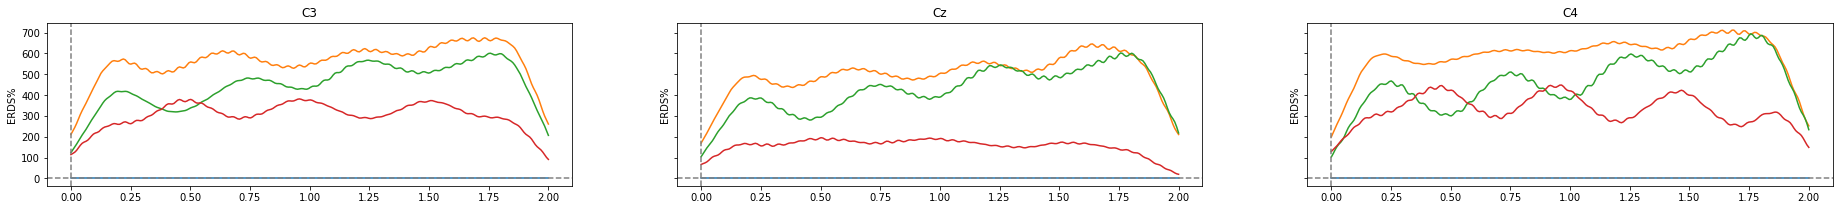

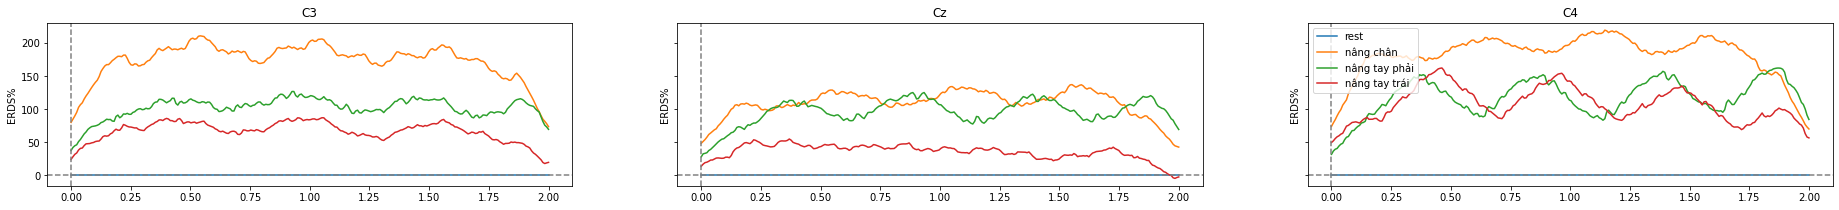

In [11]:
cols = ["C3", "Cz", "C4"]

_, axes = plt.subplots(nrows=1, ncols=len(cols), sharey='row', figsize=(32, 3))

for i in range(len(cols)):
    for k, v in alpha.items():
        axes[i].plot(np.linspace(tmin, tmax, len(v[i])), np.convolve(v[i], np.ones(32) / 32, mode='same'))
    axes[i].axhline(y=0, color='gray', linestyle='--')
    axes[i].axvline(x=0, color='gray', linestyle='--')
    axes[i].set_title(cols[i])
    axes[i].set_ylabel('ERDS%')
    
_, axes = plt.subplots(nrows=1, ncols=len(cols), sharey='row', figsize=(32, 3))
for i in range(len(cols)):
    for k, v in beta.items():
        axes[i].plot(np.linspace(tmin, tmax, len(v[i])), np.convolve(v[i], np.ones(32) / 32, mode='same'))
    axes[i].axhline(y=0, color='gray', linestyle='--')
    axes[i].axvline(x=0, color='gray', linestyle='--')
    axes[i].set_title(cols[i])
    axes[i].set_ylabel('ERDS%')
    
plt.legend(alpha.keys())

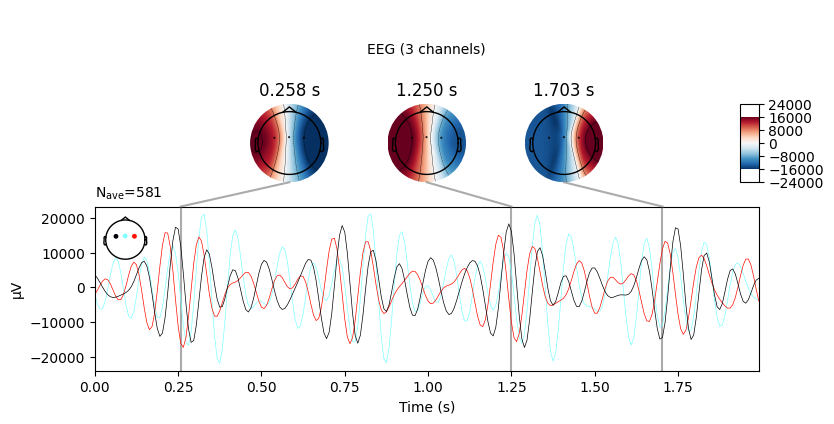

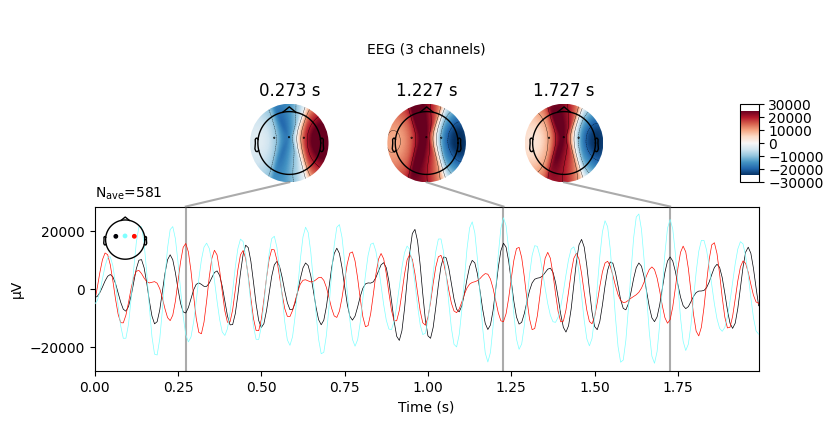

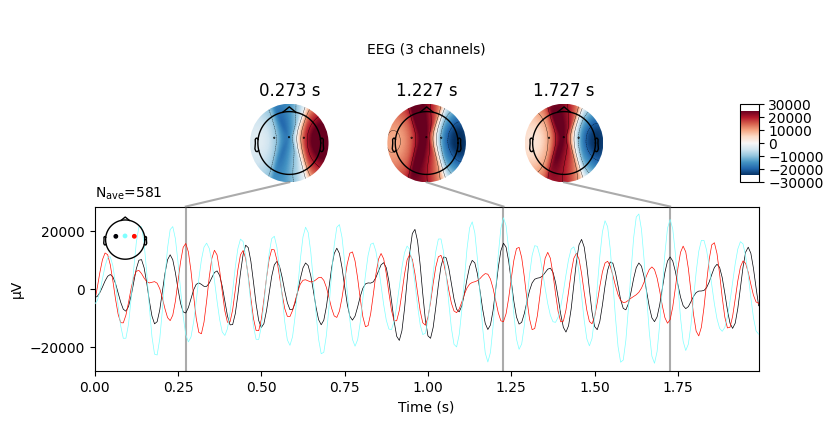

In [611]:
epochs["nâng tay trái"].copy().filter(8, 12).average().plot_joint()
epochs["nâng tay phải"].copy().filter(8, 12).average().plot_joint()

In [467]:
freqs = np.arange(4, 39)

tfr = mne.time_frequency.tfr_multitaper(epochs, freqs=freqs, n_cycles=freqs, use_fft=True, return_itc=False, average=False, decim=2)
tfr.apply_baseline([0, 1], mode="percent")

<EpochsTFR | time : [0.000000, 3.984375], freq : [4.000000, 38.000000], epochs : 11, channels : 3, ~2.3 MB>

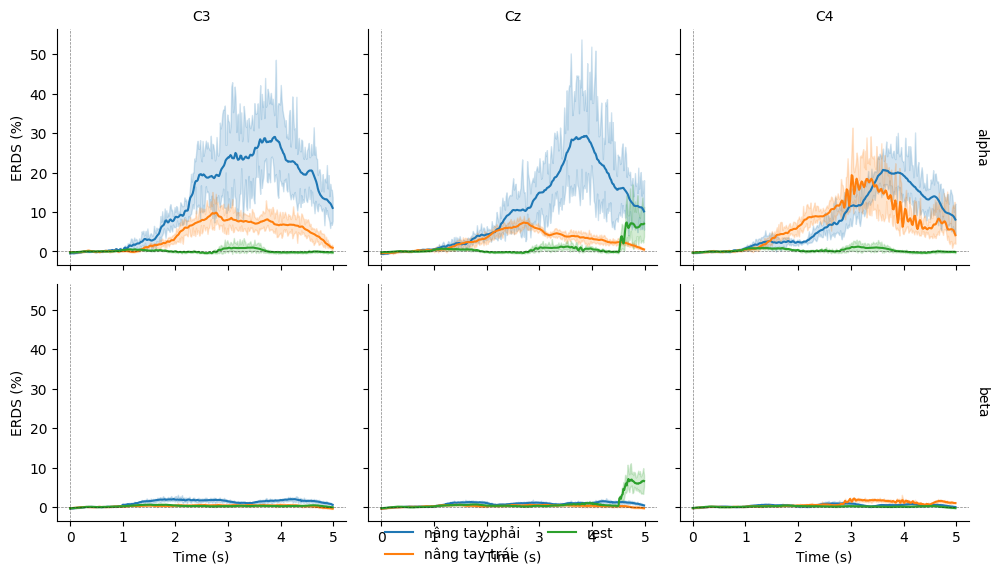

In [451]:
df = tfr.to_data_frame(time_format=None, long_format=True)

# Map to frequency bands:
freq_bounds = {'_': 0,
               'delta': 4,
               'theta': 8,
               'alpha': 12,
               'beta': 30,
               'gamma': 80}
df['band'] = pd.cut(df['freq'], list(freq_bounds.values()),
                    labels=list(freq_bounds)[1:])

# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ['alpha', 'beta']
df = df[df.band.isin(freq_bands_of_interest)]
df['band'] = df['band'].cat.remove_unused_categories()

# Order channels for plotting:
df['channel'] = df['channel'].cat.reorder_categories(('C3', 'Cz', 'C4'),
                                                     ordered=True)

g = sb.FacetGrid(df, row='band', col='channel', margin_titles=True)
g.map(sb.lineplot, 'time', 'value', 'condition', n_boot=10)
axline_kw = dict(color='black', linestyle='dashed', linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)
# g.set(ylim=(None, 1.5))
g.set_axis_labels("Time (s)", "ERDS (%)")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc='lower center')
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)

In [2]:
raw = mne.io.read_raw_edf("/home/txdat/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R04.edf", verbose=False, preload=True)

In [3]:
raw

<RawEDF | S001R04.edf, 64 x 20000 (125.0 s), ~9.8 MB, data loaded>

In [7]:
events, event_id = mne.events_from_annotations(raw)
print(event_id)
events

{'T0': 1, 'T1': 2, 'T2': 3}


array([[    0,     0,     1],
       [  672,     0,     3],
       [ 1328,     0,     1],
       [ 2000,     0,     2],
       [ 2656,     0,     1],
       [ 3328,     0,     2],
       [ 3984,     0,     1],
       [ 4656,     0,     3],
       [ 5312,     0,     1],
       [ 5984,     0,     3],
       [ 6640,     0,     1],
       [ 7312,     0,     2],
       [ 7968,     0,     1],
       [ 8640,     0,     3],
       [ 9296,     0,     1],
       [ 9968,     0,     2],
       [10624,     0,     1],
       [11296,     0,     3],
       [11952,     0,     1],
       [12624,     0,     2],
       [13280,     0,     1],
       [13952,     0,     2],
       [14608,     0,     1],
       [15280,     0,     3],
       [15936,     0,     1],
       [16608,     0,     2],
       [17264,     0,     1],
       [17936,     0,     3],
       [18592,     0,     1],
       [19264,     0,     2]])

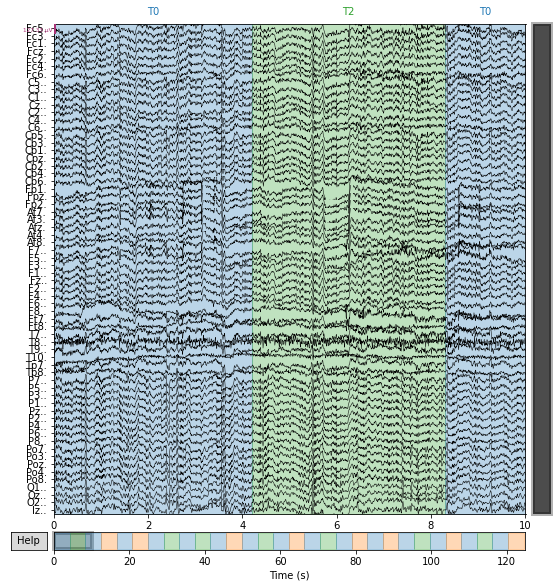

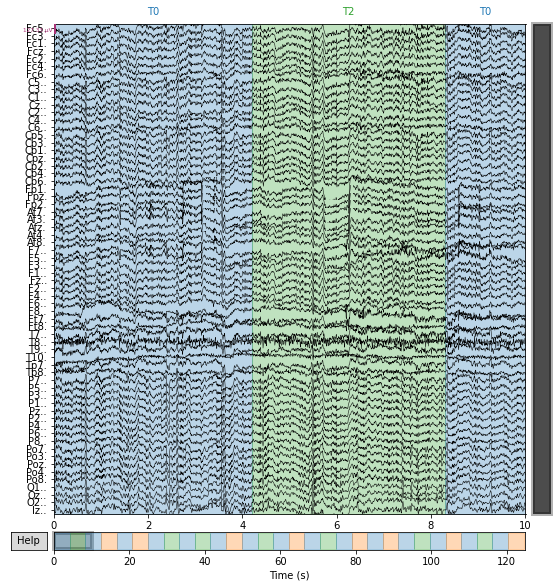

In [6]:
raw.plot(n_channels=64, scalings="auto")

In [22]:
import mne

channels = [
    # "Fp1", "Fp2",
    # "F7", "F3", "Fz", "F4", "F8",
    # "FT9", "FC5", "FC1", "FC2", "FC6", "FT10",
    # "FC5", "FC1", "FC2", "FC6",
    # "T7", "C3", "Cz", "C4", "T8",
    "C3", "Cz", "C4",
    # "CP5", "CP1", "CP2", "CP6",
    # "P7", "P3", "Pz", "P4", "P8",
    # "PO9", "O1", "Oz", "O2", "PO10",
    # "O1", "Oz", "O2",
]

In [23]:
raw = mne.io.read_raw_edf("../data/DataVIN/Official/K309/sample1/EEG.edf", verbose=False)
raw.set_montage("standard_1020")

<RawEDF | EEG.edf, 32 x 16768 (131.0 s), ~50 kB, data not loaded>

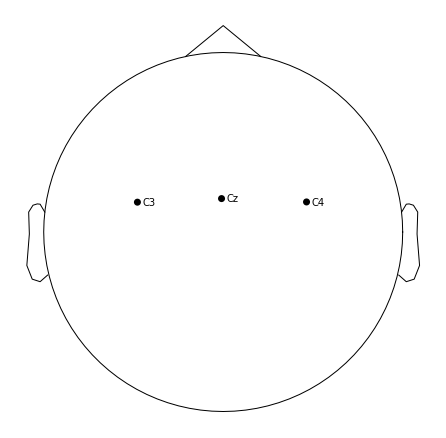

In [24]:
fig = raw.copy().pick_channels(ch_names=channels, ordered=True).plot_sensors(show_names=True)

In [25]:
fig.savefig("vinif_eeget_sensors_3c.png")

In [27]:
raw = mne.io.read_raw_edf("/home/txdat/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R04.edf", verbose=False)
raw.rename_channels(lambda x: x.strip("."))
raw.rename_channels(lambda x: x.upper())
# fmt: off
renames = {
    "AFZ": "AFz", "PZ": "Pz", "FPZ": "Fpz", "FCZ": "FCz", "FP1": "Fp1", "CZ": "Cz",
    "OZ": "Oz", "POZ": "POz", "IZ": "Iz", "CPZ": "CPz", "FP2": "Fp2", "FZ": "Fz",
}
# fmt: on
raw.rename_channels(renames)
raw.set_montage("standard_1005")

<RawEDF | S001R04.edf, 64 x 20000 (125.0 s), ~92 kB, data not loaded>

In [35]:
picks = mne.pick_types(raw.info, eeg=False, stim=True)
picks

array([], dtype=int64)

In [43]:
ch_names = list(raw.info["ch_names"])
for i in range(0, len(ch_names), 5):
    print(ch_names[i: i + 5])

# ch_names

['FC5', 'FC3', 'FC1', 'FCz', 'FC2']
['FC4', 'FC6', 'C5', 'C3', 'C1']
['Cz', 'C2', 'C4', 'C6', 'CP5']
['CP3', 'CP1', 'CPz', 'CP2', 'CP4']
['CP6', 'Fp1', 'Fpz', 'Fp2', 'AF7']
['AF3', 'AFz', 'AF4', 'AF8', 'F7']
['F5', 'F3', 'F1', 'Fz', 'F2']
['F4', 'F6', 'F8', 'FT7', 'FT8']
['T7', 'T8', 'T9', 'T10', 'TP7']
['TP8', 'P7', 'P5', 'P3', 'P1']
['Pz', 'P2', 'P4', 'P6', 'P8']
['PO7', 'PO3', 'POz', 'PO4', 'PO8']
['O1', 'Oz', 'O2', 'Iz']


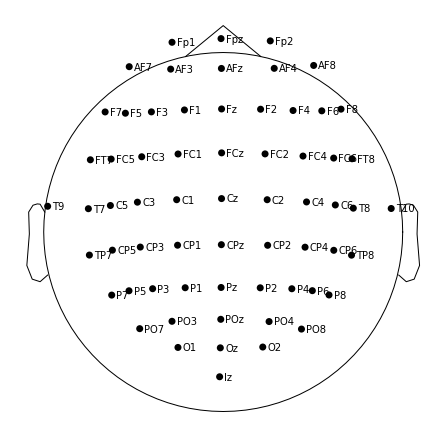

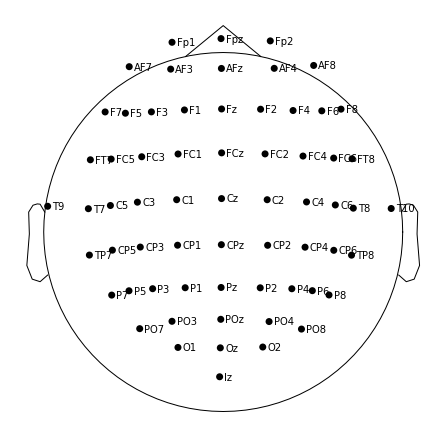

In [41]:
raw.plot_sensors(show_names=True)

In [44]:
ch_names = [
    'Fp1', 'Fpz', 'Fp2', 
    'AF7', 'AF3', 'AFz', 'AF4', 'AF8',
    'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8',
    'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8',
    'T9', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'T10',
    'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8',
    'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8',
    'PO7', 'PO3', 'POz', 'PO4', 'PO8',
    'O1', 'Oz', 'O2',
    'Iz',
]

len(ch_names)

64

In [1]:
import mne
import pickle as pkl
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
with open("../data/beetl/PHY_LR0_001_040_4-38Hz_BRD.pkl", mode="rb") as f:
    exp_ds = pkl.load(f)

Using data from preloaded Raw for 1 events and 384 original time points ...


<AxesSubplot:>

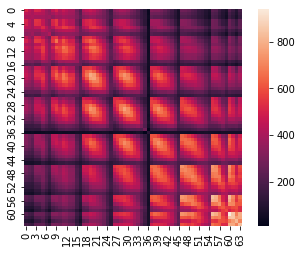

In [3]:
x = exp_ds.datasets[100].windows.get_data()[0]

sb.heatmap(np.cov(x, rowvar=True), square=True)

Using data from preloaded Raw for 1 events and 384 original time points ...


<AxesSubplot:>

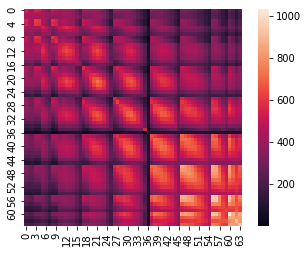

In [6]:
c = np.stack([np.cov(x, rowvar=True) for x in exp_ds.datasets[0].windows.get_data()]).mean(axis=0)
sb.heatmap(c, square=True)

<AxesSubplot:>

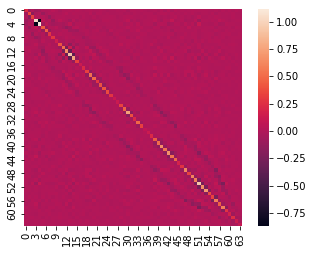

In [9]:
sb.heatmap(linalg.inv(linalg.sqrtm(c)), square=True)

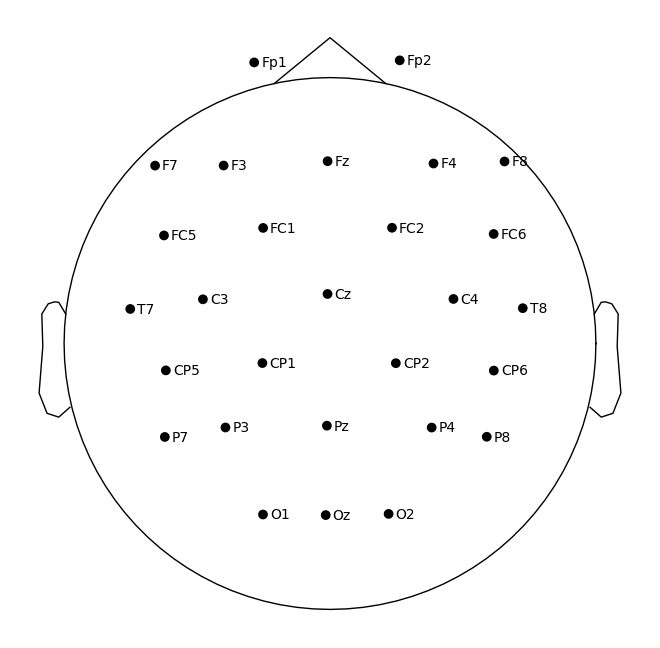

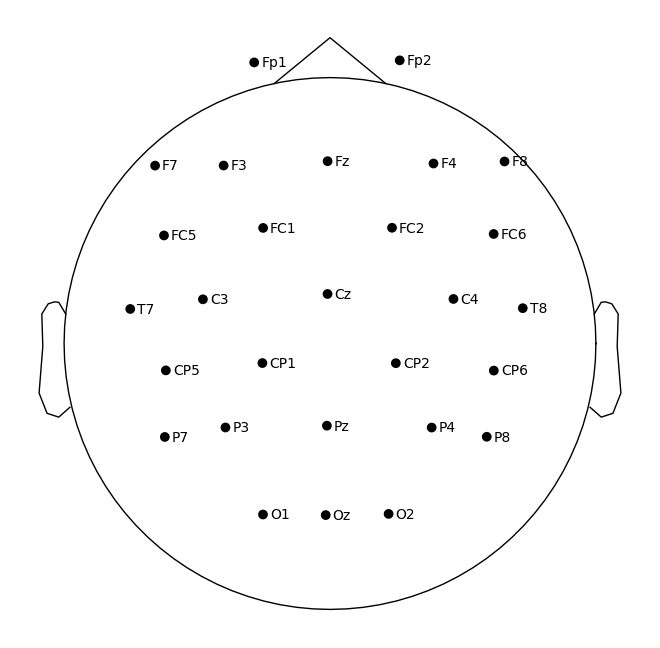

In [99]:
# mne.viz.plot_montage(epochs.get_montage())
epochs.plot_sensors(show_names=True)